In [1]:
import numpy as np
from utils import *
import math
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
n=160 #choose 160 for a challenging case
d=3
def spiral_xy(i, spiral_num):
    """
    Create the data for a spiral.

    Arguments:
        i runs from 0 to 96
        spiral_num is 1 or -1
    """
    φ = i/16 * math.pi
    r = 6.5 * ((104 - i)/104)
    x = (r * math.cos(φ) * spiral_num)/13 + 0.5
    y = (r * math.sin(φ) * spiral_num)/13 + 0.5
    return (x, y)

def spiral(spiral_num):
    return [spiral_xy(i, spiral_num) for i in range(n//2)]

a = spiral(1)
b = spiral(-1)
X_raw=2*np.concatenate((a,b),axis=0)-1
y_raw=np.concatenate((np.ones(n//2),-np.ones(n//2)))

index = np.arange(n)
np.random.seed(1)
np.random.shuffle(index)
train_num = n
training_data_np = X_raw[index[:train_num],:]
training_labels_np = y_raw[index[:train_num]]
test_data_np = X_raw[index[train_num:],:]
test_labels_np = y_raw[index[train_num:]]

In [3]:
# convex training
Hidden = 200
reg_p = 2
beta = 1e-3
params_dict = {}
method_list = ['Geometric_Algebra','Gaussian']
activation_list = ['ReLU']#,'gReLU']
np.random.seed(0)
sdim_list = [-1,1]
activation = 'ReLU'
for method in method_list:
#     for activation in activation_list:
    key = '{}'.format(method)
    params = cvx_solver_mosek(training_data_np,training_labels_np,arr_select=method,
                              Hidden=Hidden,sdim=-1,beta=beta,activation=activation)
    train_acc = cvx_solver_evaluate(training_data_np,training_labels_np,params,activation=activation)
    print('{} train: {:.2f}'.format(key, train_acc))
    params_dict[key] = params

Geometric_Algebra train: 100.00
Gaussian train: 100.00


In [4]:
# convex lasso
reg_p = 2
method = 'GA_enum'#'Geometric_Algebra'#'Gaussian'#'Geometric_Algebra'
beta = 1e-3
activation = 'Lasso'
params_lasso = cvx_solver_mosek(training_data_np,training_labels_np,arr_select=method,sdim=-1,beta=beta,
                          activation=activation,verbose=True)
train_acc = cvx_solver_evaluate(training_data_np,training_labels_np,params_lasso,activation=activation)
print('train: {:.2f}'.format(train_acc))

Convex program objective value:  0.8122728001629107
train: 100.00


In [5]:
#subsampled lasso
reg_p = 2
method = 'Geometric_Algebra'#'Geometric_Algebra'#'Gaussian'#'Geometric_Algebra'
beta = 1e-3
activation = 'Lasso'
params_lasso_sub = cvx_solver_mosek(training_data_np,training_labels_np,arr_select=method,
                                    Hidden=Hidden,sdim=-1,beta=beta,
                          activation=activation,verbose=True,aug_sym=True)
train_acc = cvx_solver_evaluate(training_data_np,training_labels_np,params_lasso_sub,activation=activation)
print('train: {:.2f}'.format(train_acc))

Convex program objective value:  6.61518195130453
train: 100.00


In [6]:
# nonconvex training
lr_list = [1e-1,1e-2,1e-3]
NN_dict = {}
train_acc_noncvx = -1
best_lr = -1
Epochs = 1000
set_seed(0)
for lr in lr_list:
    key = '{:.0e}'.format(lr)
    train_data = TensorDataset(torch.tensor(training_data_np).float(), torch.tensor(training_labels_np).float())
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=n, drop_last=True)
    NNclassifier, optimizer, scheduler = initialize_model(Hidden, D_in = 2, epochs=Epochs, lr=lr, beta=1e-3,train_dataloader=train_dataloader)
    cum_time, train_loss, test_loss, train_acc, test_acc = train(NNclassifier, optimizer, scheduler, train_dataloader, train_dataloader, epochs=Epochs, evaluation=True, freq_batch=1)
    NN_dict[key] = NNclassifier
    print('train acc: {:.2f}'.format(train_acc[-1]))
    if train_acc[-1]>train_acc_noncvx:
        best_lr = lr
        train_acc_noncvx = train_acc[-1]

Start training...

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 1 Train_acc: 48.75 Test_acc: 50.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 2 Train_acc: 50.0 Test_acc: 51.87500000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 3 Train_acc: 51.87500000000001 Test_acc: 58.12500000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (I

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 46 Train_acc: 59.375 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 47 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 48 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been depre

Epoch: 119 Train_acc: 65.625 Test_acc: 71.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 120 Train_acc: 71.875 Test_acc: 64.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 121 Train_acc: 64.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 122 Train_acc: 69.375 Test_acc: 63.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4

Epoch: 195 Train_acc: 62.5 Test_acc: 65.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 196 Train_acc: 65.0 Test_acc: 66.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 197 Train_acc: 66.25 Test_acc: 65.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 198 Train_acc: 65.0 Test_acc: 63.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 263 Train_acc: 66.25 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 264 Train_acc: 68.75 Test_acc: 66.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 265 Train_acc: 66.25 Test_acc: 67.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been

Epoch: 326 Train_acc: 66.875 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 327 Train_acc: 68.75 Test_acc: 65.625
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 328 Train_acc: 65.625 Test_acc: 67.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 329 Train_acc: 67.5 Test_acc: 66.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Int

Epoch: 397 Train_acc: 67.5 Test_acc: 66.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 398 Train_acc: 66.25 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 399 Train_acc: 68.75 Test_acc: 66.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 400 Train_acc: 66.25 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel

Epoch: 470 Train_acc: 67.5 Test_acc: 67.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 471 Train_acc: 67.5 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 472 Train_acc: 69.375 Test_acc: 67.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 473 Train_acc: 67.5 Test_acc: 68.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(

Epoch: 544 Train_acc: 69.375 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 545 Train_acc: 68.75 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 546 Train_acc: 68.75 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 547 Train_acc: 68.75 Test_acc: 68.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (In

Epoch: 612 Train_acc: 68.125 Test_acc: 68.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 613 Train_acc: 68.125 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 614 Train_acc: 68.75 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 615 Train_acc: 68.75 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (I

Epoch: 689 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 690 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 691 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 692 Train_acc: 69.375 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.

Epoch: 763 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 764 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 765 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 766 Train_acc: 69.375 Test_acc: 68.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 836 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 837 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 838 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors h

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 910 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 911 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 912 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors h

Epoch: 980 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 981 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 982 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 983 Train_acc: 69.375 Test_acc: 69.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 50 Train_acc: 66.875 Test_acc: 66.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 51 Train_acc: 66.875 Test_acc: 66.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 52 Train_acc: 66.25 Test_acc: 67.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 115 Train_acc: 61.25000000000001 Test_acc: 62.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 116 Train_acc: 62.5 Test_acc: 64.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 117 Train_acc: 64.375 Test_acc: 63.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only proce

Epoch: 175 Train_acc: 70.0 Test_acc: 71.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 176 Train_acc: 71.25 Test_acc: 71.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 177 Train_acc: 71.25 Test_acc: 71.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 178 Train_acc: 71.25 Test_acc: 71.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Inte

Epoch: 245 Train_acc: 72.5 Test_acc: 73.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 246 Train_acc: 73.75 Test_acc: 73.125
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 247 Train_acc: 73.125 Test_acc: 73.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 248 Train_acc: 73.75 Test_acc: 73.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Int

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 315 Train_acc: 75.0 Test_acc: 75.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 316 Train_acc: 75.0 Test_acc: 75.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 317 Train_acc: 75.0 Test_acc: 75.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been depr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 386 Train_acc: 76.25 Test_acc: 76.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 387 Train_acc: 76.25 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 388 Train_acc: 76.875 Test_acc: 76.25
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has b

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 449 Train_acc: 76.875 Test_acc: 77.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 450 Train_acc: 77.5 Test_acc: 77.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 451 Train_acc: 77.5 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 515 Train_acc: 76.875 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 516 Train_acc: 76.875 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 517 Train_acc: 76.875 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors h

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 586 Train_acc: 78.125 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 587 Train_acc: 76.875 Test_acc: 77.5
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 588 Train_acc: 77.5 Test_acc: 76.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has b

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 658 Train_acc: 78.75 Test_acc: 78.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 659 Train_acc: 78.75 Test_acc: 78.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 660 Train_acc: 78.75 Test_acc: 78.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has bee

Epoch: 728 Train_acc: 79.375 Test_acc: 79.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 729 Train_acc: 79.375 Test_acc: 79.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 730 Train_acc: 79.375 Test_acc: 79.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 731 Train_acc: 79.375 Test_acc: 79.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4

Epoch: 797 Train_acc: 79.375 Test_acc: 80.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 798 Train_acc: 80.0 Test_acc: 80.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 799 Train_acc: 80.0 Test_acc: 79.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 800 Train_acc: 79.375 Test_acc: 79.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Inte

Epoch: 864 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 865 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 866 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 867 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4

Epoch: 932 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 933 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 934 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 935 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4

Epoch: 998 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 999 Train_acc: 81.875 Test_acc: 81.875
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 1000 Train_acc: 81.875 Test_acc: 81.875
train acc: 81.88
Start training...

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 1 Train_acc: 50.0 Test_acc: 50.0
Intel MKL WARNING: Support of Intel

Epoch: 65 Train_acc: 59.375 Test_acc: 59.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 66 Train_acc: 59.375 Test_acc: 59.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 67 Train_acc: 59.375 Test_acc: 59.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 68 Train_acc: 59.375 Test_acc: 59.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 134 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 135 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 136 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been depr

Epoch: 202 Train_acc: 59.375 Test_acc: 59.375
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 203 Train_acc: 59.375 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 204 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 205 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 273 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 274 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 275 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streami

Epoch: 342 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 343 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 344 Train_acc: 60.62499999999999 Test_acc: 61.25000000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 345 Train_acc: 61.25000000000001 Test_a

Epoch: 413 Train_acc: 61.25000000000001 Test_acc: 61.25000000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 414 Train_acc: 61.25000000000001 Test_acc: 61.25000000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 415 Train_acc: 61.25000000000001 Test_acc: 61.25000000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 416 Train_acc: 61.25000000000001 Test_a

Epoch: 483 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 484 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 485 Train_acc: 60.62499999999999 Test_acc: 60.62499999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 486 Train_acc: 60.62499999999999 Test_a

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 550 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 551 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 552 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been depr

Epoch: 618 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 619 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 620 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 621 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE

Epoch: 688 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 689 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 690 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 691 Train_acc: 60.0 Test_acc: 60.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE

Epoch: 755 Train_acc: 58.12500000000001 Test_acc: 57.49999999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 756 Train_acc: 57.49999999999999 Test_acc: 57.49999999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 757 Train_acc: 57.49999999999999 Test_acc: 57.49999999999999
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 758 Train_acc: 57.49999999999999 Test_a

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 822 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 823 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 824 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has bee

Epoch: 891 Train_acc: 58.12500000000001 Test_acc: 58.12500000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 892 Train_acc: 58.12500000000001 Test_acc: 58.12500000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 893 Train_acc: 58.12500000000001 Test_acc: 58.12500000000001
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 894 Train_acc: 58.12500000000001 Test_a

Epoch: 959 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 960 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 961 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch: 962 Train_acc: 58.75 Test_acc: 58.75
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Inte

In [7]:
samp=200
x1=np.linspace(-1,1,samp).reshape(-1,1)
x2=np.linspace(-1,1,samp).reshape(-1,1)

Xtest=np.meshgrid(x1,x2)
# add the bias term
Xtest_raw = np.concatenate([Xtest[0].reshape(samp**2,1),Xtest[1].reshape(samp**2,1)],axis=1)
Xtest = np.concatenate([Xtest_raw,np.ones(samp**2).reshape(samp**2,1)],axis=1)

In [8]:
best_key = '{:.0e}'.format(best_lr)
best_NN_classifier = NN_dict[best_key]
Xtest_t = torch.tensor(Xtest_raw).float()
yest_noncvx = torch.sign(best_NN_classifier(Xtest_t)).detach().numpy()
pos_noncvx=np.where(np.sign(yest_noncvx)==1)
neg_noncvx=np.where(np.sign(yest_noncvx)==-1)

In [ ]:
params_dict.keys()

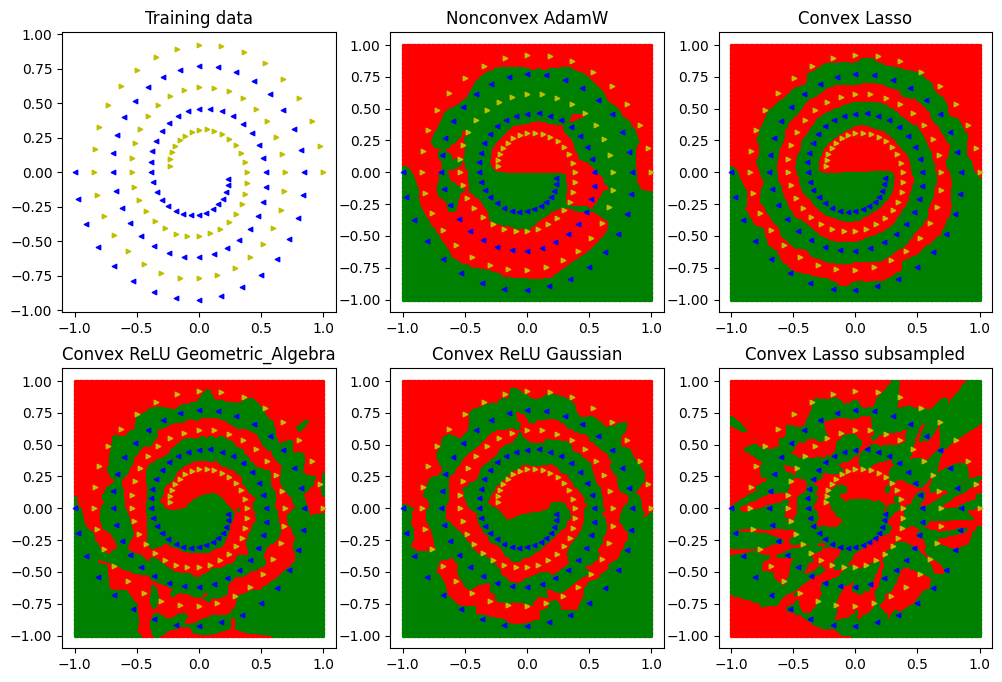

In [10]:
ind_dict = {}
X = X_raw.copy()
y = y_raw.copy()
for method in method_list:
    key = '{}'.format(method)
    params = params_dict[key]
    G, U = params
    activation = 'ReLU'
    if activation=='ReLU':
        yest_cvx=np.sum(relu(Xtest@G)-relu(Xtest@U),axis=1)
    elif activation=='gReLU':
        yest_cvx=np.sum(drelu(Xtest@G)*(Xtest@U),axis=1)

    pos_cvx=np.where(np.sign(yest_cvx)==1)
    neg_cvx=np.where(np.sign(yest_cvx)==-1)
    ind_dict[key] = [pos_cvx,neg_cvx]
        
pos = np.where(y==1)
neg = np.where(y==-1)
fig, axes = plt.subplots(2, 3,figsize=(12,8))

ax = axes[0,0]
ax.scatter(X[pos,0],X[pos,1],10,marker='>',c='y');
ax.scatter(X[neg,0],X[neg,1],10,marker='<',c='b');
ax.set_title("Training data")

ax = axes[0,1]

ax.scatter(Xtest[pos_noncvx,0],Xtest[pos_noncvx,1],2,marker='o',c='r');
ax.scatter(Xtest[neg_noncvx,0],Xtest[neg_noncvx,1],2,marker='o',c='g');
ax.scatter(X[pos,0],X[pos,1],10,marker='>',c='y');
ax.scatter(X[neg,0],X[neg,1],10,marker='<',c='b');
ax.set_title("Nonconvex AdamW")

ax = axes[0,2]
G, z, t = params_lasso
yest_cvx = relu(Xtest@G)@z+t
pos_cvx=np.where(np.sign(yest_cvx)==1)
neg_cvx=np.where(np.sign(yest_cvx)==-1)
ax.scatter(Xtest[pos_cvx,0],Xtest[pos_cvx,1],2,marker='o',c='r');
ax.scatter(Xtest[neg_cvx,0],Xtest[neg_cvx,1],2,marker='o',c='g');
ax.scatter(X[pos,0],X[pos,1],10,marker='>',c='y');
ax.scatter(X[neg,0],X[neg,1],10,marker='<',c='b');
ax.set_title("Convex {}".format('Lasso'))
ax = axes[1,2]
G, z, t = params_lasso_sub
yest_cvx = relu(Xtest@G)@z+t
pos_cvx=np.where(np.sign(yest_cvx)==1)
neg_cvx=np.where(np.sign(yest_cvx)==-1)
ax.scatter(Xtest[pos_cvx,0],Xtest[pos_cvx,1],2,marker='o',c='r');
ax.scatter(Xtest[neg_cvx,0],Xtest[neg_cvx,1],2,marker='o',c='g');
ax.scatter(X[pos,0],X[pos,1],10,marker='>',c='y');
ax.scatter(X[neg,0],X[neg,1],10,marker='<',c='b');
title = "Convex Lasso subsampled"
ax.set_title(title)

for i, method in enumerate(method_list):
    key = '{}'.format(method)
    pos_cvx,neg_cvx = ind_dict[key]
    ax = axes[1,i]
    ax.scatter(Xtest[pos_cvx,0],Xtest[pos_cvx,1],2,marker='o',c='r');
    ax.scatter(Xtest[neg_cvx,0],Xtest[neg_cvx,1],2,marker='o',c='g');
    ax.scatter(X[pos,0],X[pos,1],10,marker='>',c='y');
    ax.scatter(X[neg,0],X[neg,1],10,marker='<',c='b');
    title = "Convex {} {}".format(activation, method)
    ax.set_title(title)
fig.savefig('figures/Illus_spiral.pdf',bbox_inches='tight')

In [ ]:
# Lasso reg path based on cvxpy
p = 2
n, Embedding_Size = np.shape(training_data_np)
assert Embedding_Size==2, 'wrong input dimension'
G = np.zeros([3,n*(n-1)])
count = 0
for i in range(n):
    for j in range(i+1,n):
        xi = training_data_np[i]
        xj = training_data_np[j]
        v = (xi-xj)/np.linalg.norm(xi-xj)
        # rotate 90 degrees
        v = np.array([v[1],-v[0]])
        G[:2,count] = v
        G[2,count] = -xj@v
        G[:2,count+1] = -v
        G[2,count+1] = xi@v
        count+=2
training_data_aug = np.concatenate([training_data_np,np.ones([n,1])],axis=1)
Embedding_Size += 1

dmat= drelu(np.matmul(training_data_aug,G))

G = G/np.linalg.norm(G[:-1,:],p,axis=0)
X = relu(training_data_aug@G)
y = training_labels_np.copy()

beta_max = np.max(X.T@y)
n_betas = 10
beta_list = beta_max * np.geomspace(1, 1e-3, n_betas)
m1=G.shape[1]
z =cp.Variable(m1)
t = cp.Variable(1)
yopt = X@z+t
regularization = cp.norm(z,1)

params_list = []
for e, beta in tqdm(enumerate(beta_list)):
    cost=cp.sum_squares(yopt-training_labels_np)+beta*regularization
    prob=cp.Problem(cp.Minimize(cost))
    cvx_solver = cp.MOSEK
    prob.solve(solver=cvx_solver,verbose=False)
    z_v, t_v = z._value, t._value
    params_list.append([z_v, t_v])

In [ ]:
samp=200
x1=np.linspace(-1,1,samp).reshape(-1,1)
x2=np.linspace(-1,1,samp).reshape(-1,1)

Xtest=np.meshgrid(x1,x2)
# add the bias term
Xtest_raw = np.concatenate([Xtest[0].reshape(samp**2,1),Xtest[1].reshape(samp**2,1)],axis=1)
Xtest = np.concatenate([Xtest_raw,np.ones(samp**2).reshape(samp**2,1)],axis=1)
pos = np.where(y_raw==1)
neg = np.where(y_raw==-1)

In [ ]:
for e, beta in tqdm(enumerate(beta_list)):
    fig, ax = plt.subplots(1, 1,figsize=(8,8))
    z, t = params_list[e]
    yest_cvx = relu(Xtest@G)@z+t
    pos_cvx=np.where(np.sign(yest_cvx)==1)
    neg_cvx=np.where(np.sign(yest_cvx)==-1)
    ax.scatter(Xtest[pos_cvx,0],Xtest[pos_cvx,1],2,marker='o',c='r');
    ax.scatter(Xtest[neg_cvx,0],Xtest[neg_cvx,1],2,marker='o',c='g');
    ax.scatter(X_raw[pos,0],X_raw[pos,1],10,marker='>',c='y');
    ax.scatter(X_raw[neg,0],X_raw[neg,1],10,marker='<',c='b');
    title = r"Convex Lasso $\beta$={:.2e}".format(beta)
    ax.set_title(title)
    fig.savefig('figures/lasso_path{}.png'.format(e))